# IEEE Agentic AI Summit 2025 - Building a Knowledge Navigator Agent using Gemini, Web search and RAG tools

# **https://tinyurl.com/ya2mf4sp**

Scan to access this notebook (& [ppt](https://docs.google.com/presentation/d/1D5Cywa_cZdH55uDyZNkNfprzztX6qnw36wennCj8R-U/edit?usp=sharing))

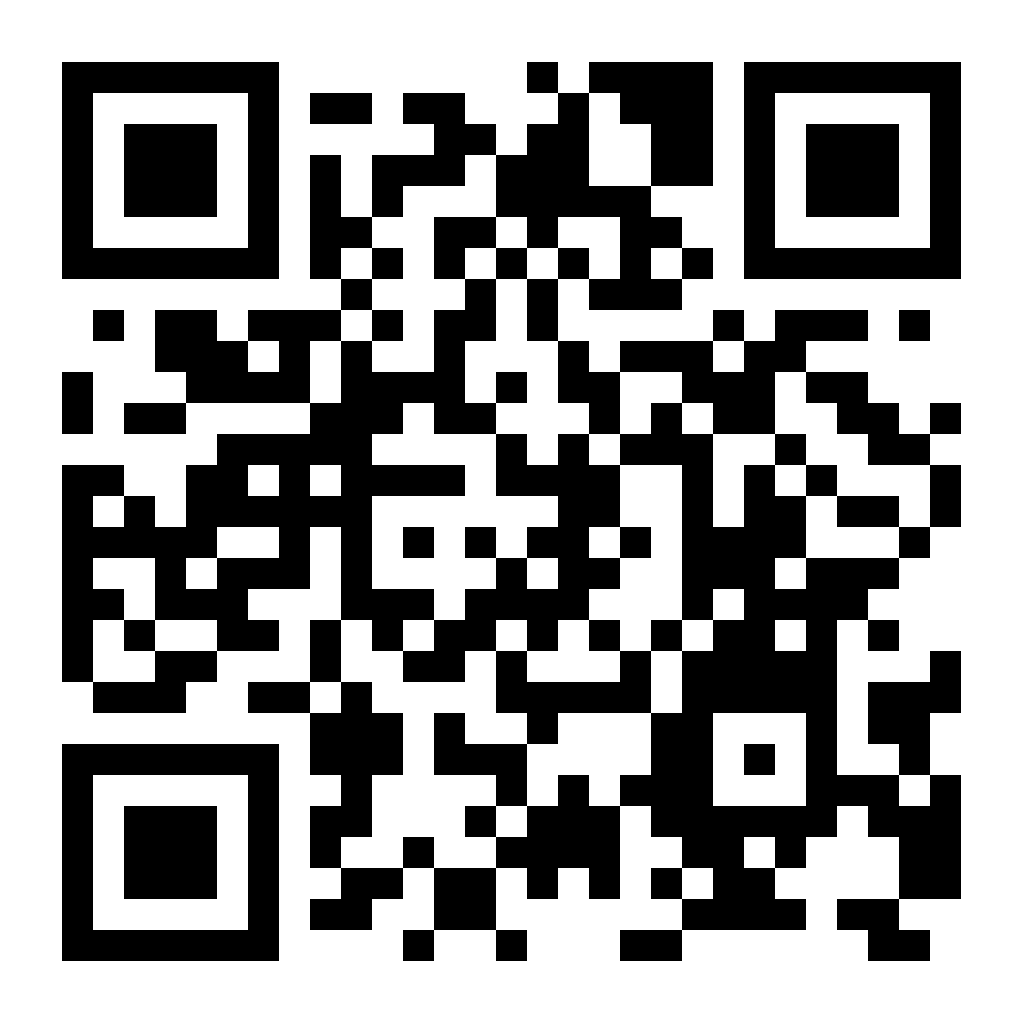


<!-- Since we’ve already seen how tools work in LLM ecosystems and how LangChain helps orchestrate them, let’s zoom out and understand why Retrieval-Augmented Generation matters — and how we can design RAG systems that actually work in the real world. -->

## 1. Introduction
LLMs are powerful, but they have a few fundamental limitations:

1. Knowledge cut-off - LLMs rely on their pretraining data, don’t know anything after their training window.

2. Lack of private/domain knowledge – They can’t know your internal documents, policies, or data.

When they lack the relevant content or domain-specific knowledge needed to answer a query, they default to producing responses that are probabilistically plausible—but not necessarily factual. In other words: *hallucinations*.

For knowledge-centric use cases, this is a serious limitation. **Accurate** outputs require **current** and **domain-specific information**, and those outputs must be grounded in a verifiable knowledge base to maintain **auditability and transparency**.

Since LLMs cannot access your internal documents or web by default, we have the RAG `(Retrieval-Augmented Generation) framework - bridges the knowledge gap` by retrieving the right information from your own trusted sources and allowing the model to generate answers built directly on that foundation.


Retrieval-Augmented Generation (RAG) is an AI framework that enhances the capabilities of large language models (LLMs) by incorporating external knowledge sources.


RAG works by retrieving relevant information from a knowledge base and using it to augment the LLM’s input, allowing the model to generate more accurate, up-to-date, and contextually relevant responses.


Slide materials (3).svg

## A typical RAG pipeline

A RAG pipeline combines information retrieval with generative AI to produce more accurate, grounded responses.

First, a user query is embedded and matched against a vector store containing indexed knowledge.

The top-relevant documents are retrieved and passed, along with the original query, to a large language model.

The model then generates an answer that incorporates the retrieved context, improving factual accuracy and reducing hallucinations.

<!-- 1. Document ingestion
2. Chunking
3. Embedding
4. Vector storage
5. Query embedding
6. Similarity search
7. Prompt construction
8. LLM generation
9. Answer (with citations) -->

### Key Components

1. Document loader (PDF, text, HTML, etc.)
2. Chunker (sliding window / token-based)
3. Embedding model
4. Vector store (ChromaDB, Pinecone, FAISS, etc.)
5. Retriever
6. Prompt template
7. Generator LLM (local or API)

Slide materials (2).svg

We will define the pipeline and implement each component step by step

## 2. Hands-on exercise

First configure Google Gemini API Access.

In [ ]:
# import getpass, os
# os.environ["GEMINI_API_KEY"] = getpass.getpass("Enter your Gemini API key: ")

In [ ]:

import os
from google.colab import userdata
os.environ["GEMINI_API_KEY"] = userdata.get('my-api-key')


### 1. Document Loader
First upload your documents to create your knowledgebase


In [ ]:

import shutil
from google.colab import files


In [ ]:

# Create a directory to store uploaded PDFs
pdf_dir = "/content/pdfs"
if os.path.exists(pdf_dir):
    shutil.rmtree(pdf_dir) # Remove existing directory if necessary
os.makedirs(pdf_dir, exist_ok=True)
print(f"Created directory: {pdf_dir}")

# Upload the PDFs from your local machine
"""
sample : https://drive.google.com/drive/folders/1MKKZZP9r_SRMaqw0xwOBrmvrqhbfbKU9?usp=sharing
"""
print("Please upload your PDF files now:")
uploaded = files.upload()

# Move the uploaded files into the created directory
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(pdf_dir, filename))
    print(f"Moved '{filename}' to '{pdf_dir}/'")

print("\nUpload complete.")


Created directory: /content/pdfs
Please upload your PDF files now:


Saving 2403.06910v1.pdf to 2403.06910v1.pdf
Moved '2403.06910v1.pdf' to '/content/pdfs/'

Upload complete.


Wish to upload more files?

In [ ]:

# Upload PDFs more your machine
print("Please upload your PDF files now:")
uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(pdf_dir, filename))
    print(f"Moved '{filename}' to '{pdf_dir}/'")

print("\nUpload complete.")


Please upload your PDF files now:



Upload complete.


Add a document loader - **PyPDFDirectoryLoader**

`PyPDFDirectoryLoader` from `langchain_community.document_loaders` is a **document loader** that automatically reads and loads **all PDF files inside a specified directory** into a format that LangChain can process.

Key Functions:
- Scans the target folder for all `.pdf` files  
- Extracts text from each PDF page by page  
- Converts the extracted text into LangChain `Document` objects  
- Adds useful metadata (e.g., file name, page numbers)  
- Returns a list of documents ready for text splitting, embedding, and indexing


In [ ]:

# Install langchain-community, pypdf
!pip install langchain-community
!pip install pypdf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 5.2 MB/s eta 0:00:00


In [ ]:

from langchain_community.document_loaders import PyPDFDirectoryLoader

# Load documents from the 'pdfs' directory
loader = PyPDFDirectoryLoader(pdf_dir)
documents = loader.load()


### 2. Chunking

Most LLMs and embedding models have a maximum "context window" or token limit (e.g., 512 tokens for some models).

Large documents often exceed these limits.

Chunking breaks them into manageable pieces that fit within the model's constraints, preventing data truncation and loss of information.

1. Improving Retrieval Accuracy and Relevance (RAG): In RAG systems, the goal is to retrieve the most relevant information from a knowledge base to answer a user's query.

2. Large chunks can contain multiple topics, diluting the focus of their vector representation and making it harder to find specific, relevant information.
Smaller, focused chunks result in more precise embeddings that better represent a single idea or topic, leading to more accurate search results.

Types:
1. Fixed-size
2. Semantic chunking
3. Structure-Aware Chunking

Tips: 200–500 tokens/chunk, 10–20% overlap


In [ ]:

!pip install -U langchain-text-splitters
from langchain_text_splitters import RecursiveCharacterTextSplitter


In [ ]:

# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
splits = text_splitter.split_documents(documents)
print(f"Loaded {len(documents)} documents and split into {len(splits)} chunks.")


Loaded 54 documents and split into 436 chunks.


In [ ]:

# Let us see how each split looks like
from pprint import pprint

print("\n=== PAGE CONTENT ===\n")
print(splits[1].page_content)

print("\n=== METADATA ===\n")
for key, value in splits[1].metadata.items():
    print(f"{key}: {value}")



=== PAGE CONTENT ===

intelligence (AI), a topic of increasing importance within EU policy discussions.
The EU has recently issued several publications emphasizing the necessity of trust
in AI, underscoring the dual nature of AI as both a beneficial tool and a potential
weapon. This dichotomy highlights the urgent need for international regulation.
Concurrently, there’s a need for frameworks that guide companies in AI develop-
ment, ensuring compliance with such regulations. Our research aims to assist law-

=== METADATA ===

producer: pdfTeX-1.40.25
creator: LaTeX with hyperref
creationdate: 2024-03-12T02:34:58+00:00
author: 
keywords: 
moddate: 2024-03-12T02:34:58+00:00
ptex.fullbanner: This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5
subject: 
title: 
trapped: /False
source: /content/pdfs/2403.06910v1.pdf
total_pages: 54
page: 0
page_label: 1


In [ ]:
my
# Add your own metadata for filtering chunks during the context retrieval phase
splits[1].metadata.update({
    "category": "policy"
})
print("\n=== PAGE CONTENT ===\n")
print(splits[1].page_content)

print("\n=== METADATA ===\n")
for key, value in splits[1].metadata.items():
    print(f"{key}: {value}")


=== PAGE CONTENT ===

intelligence (AI), a topic of increasing importance within EU policy discussions.
The EU has recently issued several publications emphasizing the necessity of trust
in AI, underscoring the dual nature of AI as both a beneficial tool and a potential
weapon. This dichotomy highlights the urgent need for international regulation.
Concurrently, there’s a need for frameworks that guide companies in AI develop-
ment, ensuring compliance with such regulations. Our research aims to assist law-

=== METADATA ===

producer: pdfTeX-1.40.25
creator: LaTeX with hyperref
creationdate: 2024-03-12T02:34:58+00:00
author: 
keywords: 
moddate: 2024-03-12T02:34:58+00:00
ptex.fullbanner: This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5
subject: 
title: 
trapped: /False
source: /content/pdfs/2403.06910v1.pdf
total_pages: 54
page: 0
page_label: 1
category: policy


### 3. Embedding

Embedding models are neural networks trained to convert text into vectors:
- Input: text (sentence, paragraph, or document chunk)
- Output: vector of numbers (dimension varies by model, e.g., 384, 768, 1536)

These vectors allow us to compute similarity between texts using metrics like:
- Cosine similarity → measures the angle between vectors
- Dot product → measures closeness in the vector space

Important: Always use the same embedding model for both indexing and querying. Otherwise, similarity scores are meaningless.

Using **GoogleGenerativeAIEmbeddings**


In [ ]:

# GoogleGenerativeAIEmbeddings class generates numerical representations (vectors) of text.
!pip install langchain-google-genai
from langchain_google_genai import GoogleGenerativeAIEmbeddings


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 1.9 MB/s eta 0:00:00


In [ ]:

# Initialize the embeddings object
embeddings = GoogleGenerativeAIEmbeddings(model="text-embedding-004", google_api_key = os.environ["GEMINI_API_KEY"])



In [ ]:
# Examples on embeddings
sample = [
    "IndiGo is facing a major operational crisis due to staff shortages and new crew regulations, leading to widespread flight cancellations and government intervention.",
    "Why are flights canceled across major airports like Delhi, Mumbai, and Bengaluru.",
    "December is considered the peak snowfall month for Kaza."
]

import numpy as np

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (
        np.linalg.norm(vec1) * np.linalg.norm(vec2)
    )


sample_embeddings = embeddings.embed_documents(sample)

print(round(cosine_similarity(sample_embeddings[0], sample_embeddings[1]), 4))
print(round(cosine_similarity(sample_embeddings[0], sample_embeddings[2]), 4))
print(round(cosine_similarity(sample_embeddings[1], sample_embeddings[1]), 4))

0.8114
0.4955
1.0


### 4. Vector Stores

What vector stores do:
- Store embeddings + metadata
- Perform fast vector similarity search
- Support persistence and filters


We will use **chromadb** in this session


In [ ]:
# Installing relevant dependencies
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.6 MB/s eta

In [ ]:

# Steps to create vector store and set up retriever
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)


Peek inside the vectorstore?

In [ ]:


# Get the internal Chroma collection
collection = vectorstore._collection

# Peek at stored items
data = collection.peek(limit=5)

# What you can inspect
for i in range(len(data["ids"])):
    print(f"\n--- Document {i + 1} ---")
    print("ID:", data["ids"][i])

    print("Content:")
    print(data["documents"][i])

    print("Metadata:")
    print("Metadata:", data["metadatas"][i] or {})

    print("Embedding (first 5 dims):")
    emb = data["embeddings"][i]
    print(emb[:5], "...", f"(dim={len(emb)})")



--- Document 1 ---
ID: 1961ffd4-d3fe-4426-b86c-18ea1f9db8d4
Content:
November 2023
Responsible Artificial Intelligence: A
Structured Literature Review
Sabrina G ¨OLLNER a,1, Marina TROPMANN-FRICK a and Boˇstjan BRUMEN b
a Department of Computer Science, Hamburg University of Applied Sciences
b Faculty of Electrical Engineering and Computer Science, University of Maribor
Abstract. Our research endeavors to advance the concept of responsible artificial
intelligence (AI), a topic of increasing importance within EU policy discussions.
Metadata:
Metadata: {'keywords': '', 'source': '/content/pdfs/2403.06910v1.pdf', 'author': '', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'title': '', 'page_label': '1', 'page': 0, 'total_pages': 54, 'subject': '', 'trapped': '/False', 'creationdate': '2024-03-12T02:34:58+00:00', 'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'moddate': '2024-03-12T02:34:58+00:00'}
Embedding (

### 5. Retrieval Strategies

Retriever is the component responsible for finding the most relevant pieces of information from your knowledge base (document chunks) before the LLM generates an answer.

In this step, similarity search is performed, query vector with compared document vectors and top-k closest vectors (most relevant chunks) are returned

Types of Retrievers in LangChain:

| Retriever | Description |
|-----------|-------------|
| `VectorStoreRetriever` | Uses a vector store (FAISS, Chroma, Pinecone, etc.) to retrieve top-k chunks based on embeddings |
| `KNNRetriever` | Classic nearest-neighbor search in a vector space |
| `SemanticRetriever` | Advanced retriever that can use embeddings and optionally metadata filters |
| `BM25Retriever` | Keyword-based retrieval (less semantic, faster, classic IR) |


In [ ]:

# Configure retriever with explicit search parameters
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": 5
    }
)

print("Retriever configured with similarity search (k=5)")


Retriever configured with similarity search (k=5)


In [ ]:

# Examples on retriever, and try some queries
# query = "Santa distributes christmas gifts to good kids only"
query = "Explain responsible AI framework"


In [ ]:

docs = retriever.invoke(query)

for i, doc in enumerate(docs):
    print(f"\nResult {i+1}")
    print(doc.page_content[:300])



Result 1
We define Responsible AI as an interdisciplinary and dynamic process: it goes be-
yond technology and includes laws (compliance and regulations) and society standards
such as ethics guidelines and the Sustainable Development Goals.
Figure 3. Pillars of the Responsible AI framework
Figure 3 shows tha

Result 2
responsible AI. Drawing from this analysis, we propose an approach for develop-
ing a future framework centered around this concept. Our findings advocate for a
human-centric approach to Responsible AI. This approach encompasses the imple-
mentation of AI methods with a strong emphasis on ethics, mo

Result 3
Responsible AI ishuman-centered and ensures users’trust through ethical ways of
decision making. The decision-making must be fair, accountable, not biased, with good
intentions, non-discriminating, and consistent with societal laws and norms. Responsible
AI ensures, that automated decisions are expl

Result 4
As mentioned in the sections before, the terms defining ”

Try metadata filtering like shown below - remember category "policy"


In [ ]:

retriever = vectorstore.as_retriever(
    search_kwargs={
        "k": 5,
        "filter": {
            "category": "policy"
        }
    }
)

print("Retriever configured with metadata filtering.")

#the retriever takes the query, computes its embedding, and finds relevant documents
docs = retriever.invoke(query)

for i, doc in enumerate(docs):
    print(f"\nResult {i+1}")
    print(doc.page_content[:300])


Retriever configured with metadata filtering.

Result 1
intelligence (AI), a topic of increasing importance within EU policy discussions.
The EU has recently issued several publications emphasizing the necessity of trust
in AI, underscoring the dual nature of AI as both a beneficial tool and a potential
weapon. This dichotomy highlights the urgent need f


You can look for similarity scores as well. To access similarity scores, you need to interact directly with the underlying vector store, because **as_retriever()** abstracts away the scores.

Using **similarity_search_with_score**


In [ ]:

docs_and_scores = vectorstore.similarity_search_with_score(
    query,
    k=3
)

THRESHOLD = 0.5

docs = [
    (doc, score) for doc, score in docs_and_scores
    if score > THRESHOLD
]

if not docs:
    print("No similar context chunk found")
else:
    for i, (doc, score) in enumerate(docs, start=1):
        print(f"\nResult {i}")
        print(f"Similarity score: {score}")
        print(doc.page_content[:300])
        print(doc.metadata.get('title'))


Result 1
Similarity score: 0.5002422332763672
We define Responsible AI as an interdisciplinary and dynamic process: it goes be-
yond technology and includes laws (compliance and regulations) and society standards
such as ethics guidelines and the Sustainable Development Goals.
Figure 3. Pillars of the Responsible AI framework
Figure 3 shows tha


Result 2
Similarity score: 0.5203720927238464
responsible AI. Drawing from this analysis, we propose an approach for develop-
ing a future framework centered around this concept. Our findings advocate for a
human-centric approach to Responsible AI. This approach encompasses the imple-
mentation of AI methods with a strong emphasis on ethics, mo


Result 3
Similarity score: 0.5305084586143494
Responsible AI ishuman-centered and ensures users’trust through ethical ways of
decision making. The decision-making must be fair, accountable, not biased, with good
intentions, non-discriminating, and consistent with societal laws and norms. Responsible


### 6. Prompting in RAG

The prompting step is where the LLM is guided to generate the final answer using the retrieved context.

We create a prompt template that typically includes:
1. System instructions
2. Retrieved context
3. Citation format
4. The user question

Example instructions: “Use only the provided context”, “If you don't know, say so”


In [ ]:
# Installing dependencies
!pip install langchain-core

In [ ]:

from langchain_core.prompts import ChatPromptTemplate

prompt_template = """
Answer the question using ONLY the context below. If you don't know, say so.

For every factual statement, cite the chunk number(s) in square brackets.
Do NOT make up sources.

Context:
{context}

---

Question: {question}

---

Output format:
Answer:
<your answer with citations like [1], [2]>

Citations:
- [1] <title>
- [2] <title>

"""
rag_prompt = ChatPromptTemplate.from_template(prompt_template)


### 7. LLM Generation Layer

The LLM Generation Layer is the step where the language model (LLM) actually generates the answer using the retrieved context and the prompt.


In [ ]:

# Import necessary modules from LangChain
from langchain_google_genai import ChatGoogleGenerativeAI  # Google Gemini LLM wrapper
from langchain_core.runnables import RunnablePassthrough  # Allows passing values through without modification
from langchain_core.output_parsers import StrOutputParser  # Parser to convert LLM outputs to string


# Initialize the Google Gemini LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=os.environ["GEMINI_API_KEY"],
    temperature=0.2,
)

# Helper function to format retrieved documents for use in a prompt
def format_docs(docs):
    """
    Takes a list of documents retrieved from a vector store and formats them
    into a string suitable for inclusion in a prompt.

    Args:
        docs: List of document objects with `metadata` and `page_content`.

    Returns:
        A string where each document is numbered and displays its title and content.
    """
    formatted = []
    for i, doc in enumerate(docs):
        title = doc.metadata.get("title", "Unknown Source")
        formatted.append(
            f"[{i+1}] Title: {title}\n{doc.page_content}"
        )
    return "\n\n".join(formatted)

# Construct a retrieval-augmented generation (RAG) chain
rag_chain = (
    {
        "context": retriever | format_docs,  # Retrieve documents and format them
        "question": RunnablePassthrough()    # Pass the question through unchanged
    }
    | rag_prompt       # Insert the context and question into a prompt template
    | llm             # Generate a response using the LLM
    | StrOutputParser()  # Ensure the output is a clean string
)


### 8. Query Embedding and answer generation

**invoke()** runs the full RAG chain with the user’s question

In [ ]:

# Try some question, pull answer and citations
# query = "Are there any responsible AI inititaives taken in India?"
query = "Are there any responsible AI inititaives?"
answer = rag_chain.invoke(query)
print(answer)

# query = "Are there any responsible AI inititaives taken in India?"


Answer: Yes, there are initiatives related to responsible AI. The EU has emphasized the necessity of trust in AI through several publications [1]. There is also an urgent need for international regulation [1] and for frameworks that guide companies in AI development to ensure compliance with such regulations [1].

Citations:
- [1] Title: intelligence (AI), a topic of increasing importance within EU policy discussions.


Takehome assignment: deduplicate the citations!

Now define the **lookup** as a tool for our **knowledge agent**

In [ ]:

def rag_kb_lookup(query: str) -> str:
    """Return last result"""
    return str(rag_chain.invoke(query))


# Knowledge Navigator Agent

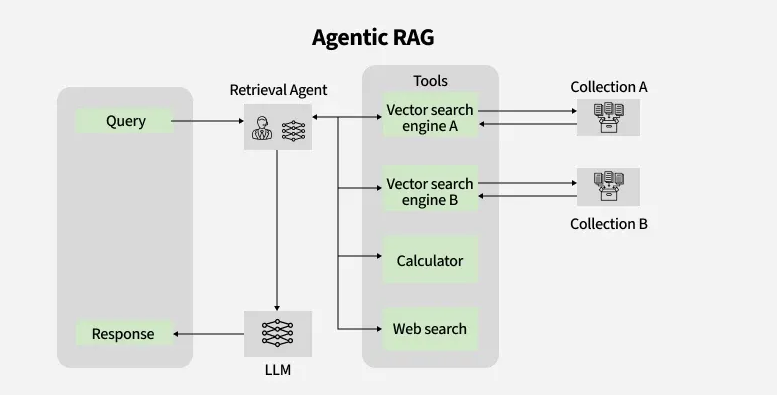



## What we learned so far

###  Agent:
An LLM that decides and acts. In our context, the agent reads a user query, decides which tools to call (search the web, consult docs, fetch a YouTube transcript, perform a calculation), orchestrates those tools, and synthesizes the final answer.

### RAG (Retrieval-Augmented Generation):
A method that augments a generative model with external knowledge. Instead of answering purely from its weights, the model retrieves relevant documents (or passages) from a vector store and then generates an answer grounded in those retrieved passages.

Traditional RAG Pipeline

User query → Retriever (vector DB) → top-K searches → LLM prompt (query+passages) → Generated answer


## What happens when We add Agentic Power to RAG?

### Key Points to Note:

1) Vanilla RAG just retrieves once and generates. (static in nature)

2) Lacks dynamic retrieval,

3) Agentic RAG can decide when to retrieve, how many times to retrieve, which tool to use, and whether the retrieved context is even good.

So instead of a fixed pipeline, we get this:

1.   Agent reads the user query
2.   Agent decides: “Do I need retrieval? Or something else?”
3.   If needed, the agent calls a RAG tool (like your youtube_rag, document search)
4.   Agent inspects the response
5.   If context is insufficient, agent may:

        *   retrieve again
        *   List item
        *   refine the query
        *   summarize the result
        *   call additional tools

Finally, it produces a polished answer

The system becomes dynamic, self-correcting, and tool-aware.

## So What Is Agentic RAG?

Agentic RAG =
RAG retrieval + the decision-making ability of an LLM agent to choose the right knowledge base.

It is a pipeline where:

an Agent orchestrates retrieval

*   RAG acts as a tool
*   the Agent performs multi-step reasoning
*   the Agent can call the RAG tool repeatedly
*   the Agent ensures the final answer is grounded, complete, and correct
*   It is not “just RAG,” it is RAG + planning + tool selection + verification.

###Summary

Agentic RAG = Autonomous LLM Agents + RAG as a tool.
Instead of a fixed retrieval pipeline, the agent dynamically decides when and how to retrieve, refine, and assemble information — resulting in smarter, more reliable, multi-step reasoning.


## Install Dependencies

Install Required Libraries
In this first step, we install langchain, Google’s Gemini integration, and DuckDuckGo Search (for getting information from Website).
These packages enable our agent to run tool-based reasoning and search the web.

In [ ]:

!pip install langchain-classic
!pip install langchain-core

# for search tool: A metasearch library that aggregates results from diverse web search services.
!pip install ddgs
!pip install -U youtube-transcript-api
!pip install -U chromadb
!pip install -U langchain-chroma

!pip install langchain-classic
!pip install langchain-google-genai --upgrade
!pip install -U langchain-text-splitters



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.1/485.1 kB 7.6 MB/s eta 0:00:00


## Import Core Modules

We now import LangChain components for building the agent,
along with utilities for web search and date operations.
These imports form the foundation for tool creation and model execution.

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_classic.agents import AgentExecutor, create_react_agent
from langchain_classic.tools import Tool
from langchain_core.prompts import ChatPromptTemplate
from ddgs import DDGS
from urllib.parse import urlparse
import re
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
!!pip install -U langchain-community

['Requirement already satisfied: langchain-community in /usr/local/lib/python3.12/dist-packages (0.4.1)',
 'Requirement already satisfied: langchain-core<2.0.0,>=1.0.1 in /usr/local/lib/python3.12/dist-packages (from langchain-community) (1.1.2)',
 'Requirement already satisfied: langchain-classic<2.0.0,>=1.0.0 in /usr/local/lib/python3.12/dist-packages (from langchain-community) (1.0.0)',
 'Requirement already satisfied: SQLAlchemy<3.0.0,>=1.4.0 in /usr/local/lib/python3.12/dist-packages (from langchain-community) (2.0.44)',
 'Requirement already satisfied: requests<3.0.0,>=2.32.5 in /usr/local/lib/python3.12/dist-packages (from langchain-community) (2.32.5)',
 'Requirement already satisfied: PyYAML<7.0.0,>=5.3.0 in /usr/local/lib/python3.12/dist-packages (from langchain-community) (6.0.3)',
 'Requirement already satisfied: aiohttp<4.0.0,>=3.8.3 in /usr/local/lib/python3.12/dist-packages (from langchain-community) (3.13.2)',
 'Requirement already satisfied: tenacity!=8.4.0,<10.0.0,>=8

In [ ]:
from langchain_community.document_loaders import YoutubeLoader
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_classic.tools import Tool

In [ ]:
from langchain_community.document_loaders import YoutubeLoader
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_classic.tools import Tool
from langchain_classic.agents import AgentExecutor, create_react_agent
from langchain_community.embeddings import HuggingFaceEmbeddings
from urllib.parse import urlparse


llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=os.environ["GEMINI_API_KEY"],
    temperature=0.2,
)


# # Step 1: Using Transformers based embedding model
# embeddings = HuggingFaceEmbeddings(
#     model_name="sentence-transformers/all-MiniLM-L6-v2"
# )

# Initialize the embeddings object
embeddings = GoogleGenerativeAIEmbeddings(model="text-embedding-004", google_api_key = os.environ["GEMINI_API_KEY"])

## Define Tools: A basic caculator, web search, youtube transcripts search, etc


Define Tools that the agent can use - and the agent will automatically decide when to call these tools based on user queries.

### WebSearch Tool

This tool gives agent the ability to search the internet in real time and return clean, trustworthy results.

# How it works

It sends the user’s question to DuckDuckGo Search. It fetches the top 6 article links. It extracts the following:


*   Title
*   Summary/snippet
*   URL
*   Source domain


It checks if the source is in a list of trusted organizations (Google, Microsoft, Harvard, AWS, Lakera, DataCamp, etc.)

In [ ]:
# Define tools for websearch

# -------------------------
# Trusted High-Credibility Domains
# -------------------------

# depends on the usecase you are nuil finding  - filter the web search results based on the your custom/chosen domains.
CHOSEN_DOMAINS = {
    "google.com",
    "ai.google",
    "deepmind.com",
    "microsoft.com",
    "azure.com",
    "aws.amazon.com",
    "harvard.edu",
    "datacamp.com",
    "lakera.ai",
}


def get_domain(url: str) -> str:
    try:
        netloc = urlparse(url).netloc.lower()
        return netloc.replace("www.", "")
    except:
        return "unknown"


# ---------------------------------------------
# Web Search Tool: Cleaner UI + Trust Score
# ---------------------------------------------
def web_search(query: str) -> str:
    """Search the web and return nicely formatted trusted sources."""

    results = DDGS().text(query, max_results=6)

    if not results:
        return "No relevant information found."

    output_lines = ["## Web Search Results", ""]

    for idx, r in enumerate(results):
        title = r.get("title", "No Title")
        snippet = r.get("body", "").strip()
        url = r.get("href", "")
        domain = get_domain(url)

        # Credibility Scoring
        if domain in CHOSEN_DOMAINS:
            credibility = "🟢 **Trusted Source**"
        elif idx < 2:
            credibility = "🟡 High (Top-ranked result)"
        elif idx < 4:
            credibility = "🟠 Medium"
        else:
            credibility = "🔴 Low / Possible Rumor"

        output_lines.append(
          (
              f"### 🔗 [{title}]({url})\n"
              f"**Source:** `{domain}`\n"
              f"**Credibility:** {credibility}\n"
              f"**Summary:** {snippet}\n"
          )
      )
    return "\n".join(output_lines)

In [ ]:
def rag_kb_lookup(query: str) -> str:
    """Return last result"""
    return str(rag_chain.invoke(query))

In [ ]:
# Adding some more trivial tools

def calculator(query: str) -> str:
    """
    Perform a mathematical operation on two comma-separated integers.
    Supported formats:
    - "add 4,5"
    - "subtract 10,3"
    - "multiply 6,7"
    """
    parts = query.lower().split()
    if len(parts) != 2:
        return "Invalid format. Use: add|subtract|multiply number1,number2"

    operation, numbers = parts
    try:
        a, b = map(int, numbers.split(","))
    except Exception:
        return "Invalid numbers format. Use: number1,number2"

    if operation == "add":
        result = a + b
    elif operation == "subtract":
        result = a - b
    elif operation == "multiply":
        result = a * b
    else:
        return "Unsupported operation."

    #memory["last_result"] = result
    return str(result)

# def recall_memory(_: str) -> str:
#     """Return last result"""
#     return str(memory.get("last_result", "No memory stored yet"))



## YouTube-RAG Tool — Overview

The youtube_rag tool allows you to take any publicly available YouTube video and turn it into a Retrieval-Augmented Generation (RAG) question-answering system.

### What the Tool Does?

You give it a YouTube URL and a question, and it returns:

The video’s transcript (automatically fetched)

A chunked + vector-indexed version stored inside an in-memory Chroma DB

A context-aware answer generated using RAG

In [ ]:
#This vector db is defined only till the next video youtube query comes
# Take home: Make the persistent vector DB and every toe there is anew vieo transprtion req, u can also update the metadata for title and URL .If data not founfd, then only it runs the transcritpion sevice


def youtube_rag(video_and_question: str) -> str:
    """
    Provides the transcription of a YouTube video and the answer to a question given to it.
    Input format (strict): '<youtube_url> || <question>'
    Example: 'https://www.youtube.com/watch?v=dQw4w9WgXcQ || What is the summary?'
    """
    # try:
    #     video_url, question = [part.strip() for part in video_and_question.split("||", 1)]
    # except Exception:
    #     return "Error: Please call this tool as '<youtube_url> || <your question>'"

    # FIX: Remove parameter label added by the agent
    if video_and_question.startswith("video_and_question:"):
        video_and_question = video_and_question.split(":", 1)[1].strip()

    try:
        video_url, question = [part.strip() for part in video_and_question.split("||", 1)]
    except Exception:
        return "Error: Please call this tool as '<youtube_url> || <your question>'"


    loader = YoutubeLoader.from_youtube_url(video_url)
    docs = loader.load()  # Usually one Document with all transcript

    print(docs[0:800])

    print("=================== stage 3: Chunking Stage ===================================")

    # Step 3: Control chunking
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
    )
    chunks = splitter.split_documents(docs)
    if not chunks:
        return "No transcript found to process."

    print("=================== stage 4: Store the Embeddings in Chroma DB ===================================")
    # Step 4: Build in-memory Chroma DB
    vectordb = Chroma.from_documents(
        chunks,
        embedding=embeddings,
    )
    retriever = vectordb.as_retriever(search_kwargs={"k": 4})

    print("=================== stage 5: Retrieve context for RAG ===================================")
    # Step 5: Retrieve context for RAG
    relevant_docs = retriever.invoke(question)
    context = "\n\n".join([d.page_content for d in relevant_docs])


    print("Context retrieved: ", context)

    # Step 6: Format prompt and run LLM
    print("=================== stage 6: Format Prompt and run LLM ===================================")
    rag_prompt = ChatPromptTemplate.from_template(
        "You are a helpful agent. Use the context below to answer the question.\n"
        "Context:\n{context}\n\n"
        "Question: {question}\n\n"
        "If the context isn’t enough, say you are unsure"
    )
    messages = rag_prompt.format_messages(context=context, question=question)
    resp = llm.invoke(messages)
    return resp.content

## Create Tool Schema for LangChain


Convert Functions into Tool Classes
LangChain expects tools in a standardized format.
Here, we wrap our Python functions into LangChain Tool objects
so that the agent can execute them when required.

In [ ]:
tools = [
    Tool(
        name="calculator",
        func=calculator,
        description="Perform math operations: add|subtract|multiply x,y"
    ),
    Tool(
        name="web_search",
        func=web_search,
        description="Search the web for recent updates"),
    # Tool(
    #     name="recall_memory",
    #     func=recall_memory,
    #     description="Returns last stored result"),
    Tool(
        name="rag_kb_lookup",
        func=rag_kb_lookup,
        description="Look into this knowledgbase for responsible AI frameworks defined by IndiaAI, IBM, Microsoft and other research organisations"),
    Tool(
        name="youtube_rag",
        func=youtube_rag,
        description="Transcribes the video and answers the question from videos",
        args_schema=None)  # prevents adding param name in the input
]

## Create the Agent Prompt

Build System Prompt
Prompts define your agent’s persona and instructions.

In [ ]:
# -----------------------
# Strict ReAct Agent Prompt
# -----------------------

# persona
# tools exposed to the agent
system_message = """
You are a reliable friendly AI assistant that decides when to call and use tools to help the user.
Always respond in a warm, conversational tone.


TOOLS AVAILABLE:
{tools}
Tool names: {tool_names}

RULES (must follow EXACTLY)
- Use tools ONLY when needed
- When using a tool, follow this format EXACTLY:

Thought: Should I use a tool? Think step by step
Action: <tool name>
Action Input: <ONLY the raw input expected by tool>

After tool returns result:
Observation: <tool output>

If the answer is complete:
Final Answer: <direct response to user>

VERY IMPORTANT:
- Do NOT add text inside Action Input that isn’t part of parameters.
- Do NOT calculate results yourself — let tools compute.
- If referring to old result, use `recall_memory`.
- If no tool required: respond with Final Answer directly.
- When using youtube_rag: Action Input MUST be exactly '<youtube_url> || <question>' (NO parameter names!)

"""


# -----------------------
# Create Prompt
# -----------------------
agentprompt = ChatPromptTemplate.from_messages([
    ("system", system_message + "\nTools available: {tools}\nTool names: {tool_names}"),
    ("human", "{input}"),
    ("assistant", "{agent_scratchpad}")
])

## Instantiate Gemini LLM

Initialize the Gemini LLM
We now load Gemini 1.5 Flash through LangChain,
which supports function calling + reasoning steps.
This model will act as the "brain" of the agent.

In [ ]:

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",   # <-- REQUIRED: valid model name
    api_key=os.environ["GEMINI_API_KEY"],
    temperature=0.2,
)

## Create the Agent and Executor


Assemble the Tool-Aided Agent by combining:
1. LLM
2. Tools
3. System Prompt
into a single AgentExecutor

In [ ]:
from langchain_classic.agents import AgentExecutor, create_react_agent

# Create Agent
agent = create_react_agent(
    llm=llm,
    tools=tools,
    prompt=agentprompt,
)

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True
)

## Test: Tool-Based Math Calculation and Web Search

Let’s confirm the agent uses the add tool instead of guessing the answer.

The model should output:
1. Thought
2. Tool selection
3. Final Answer

In [ ]:
# -----------------------
# React agent - test run
# -----------------------


print("YOUTUBERAG TOOL CALLING..")
response = agent_executor.invoke({
    "input": "https://www.youtube.com/watch?v=BZbjqiRvJPA || What does Sam Altman says on AI governance, ethics, and innovation"
})
print("\n🤖 Final Output:", response["output"])


YOUTUBERAG TOOL CALLING..


> Entering new AgentExecutor chain...
Sounds like an interesting video! Let's get that transcribed for you and find out what Sam Altman has to say.

Thought: Should I use a tool? Think step by step
Action: youtube_rag
Action Input: https://www.youtube.com/watch?v=BZbjqiRvJPA || What does Sam Altman says on AI governance, ethics, and innovation[Document(metadata={'source': 'BZbjqiRvJPA'}, page_content="so I would love if you could you touched on this but but just describe in a little bit more detail how and why you felt like you had to move from a nonprofit structure to a for-profit structure and like whe did was that like a light bulb going off or the simple the simple thing was we just needed vastly more Capital than we thought we could attract as not that we thought we tried yeah that we were able to attract as a nonprofit you know we knew that scaling computers was going to be important but we still still really underestimated how much we need to scale th

In [ ]:
"""
DEBUG:
queries = [
    "Add 10 and 100 using the tool",
    "Multiply the last result by 5",
    "What was my last answer?",
    "https://www.youtube.com/watch?v=BZbjqiRvJPA || What does Sam Altman says on AI governance, ethics, and innovation",
    "Is India doing something about creating responsible AI?",
    "Is google doing somehting on developing responsible AI?"
]
for q in queries:
    print("\n Query:", q)
    result = agent_executor.invoke({"input": q})
    print(" Final Output:", result["output"])

"""


# Langchain lib to explore further
# Fucndamental touch up on Agentic RAG. Always there is more to learn . SO I will encourgade u guys to dive deep into the essentioals of how Agentic solutions can help solving a problem

Ask away your questions - the agent knows when to navigate to web, or look into a static knowledgebase, or look into youtube videos to fetch you the information you are looking for!

In [ ]:

while True:
    user_input = input("User: ")
    if user_input.lower() in {"exit", "quit"}:
        break

    result = agent_executor.invoke({"input": user_input})
    print("Agent:", result["output"])
    print("-" * 50)